# 1. Libraries

In [2]:
import IPython
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import random
import itertools
import os
import torch
#import torchtext; #requires downgrading torch
#pip install torch==2.2.2
#pip install torchtext==0.17.2
import tensorflow as tf
import tensorflow.keras as k
import tf_keras
import sklearn
import sklearn.decomposition
import math
import time

In [3]:
from itertools import combinations
from collections import Counter
from collections import defaultdict
from numpy import trapz
from scipy import spatial, stats
from scipy.integrate import simpson
from scipy.interpolate import splrep, BSpline
from scipy.ndimage import uniform_filter1d
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.metrics import accuracy_score, precision_score, recall_score, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tqdm.autonotebook import tqdm, trange

C:\Users\leona\AppData\Local\Temp\ipykernel_1636\3954474801.py:22: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [4]:
import wordninja
from sentence_transformers import SentenceTransformer, util

# 2. Datasets

In [5]:
path_OC3FO_schema_elements_dataset = "https://raw.githubusercontent.com/leotraeg/CollaborativeScoping/refs/heads/main/data/OC3FO_schema_elements_dataset.csv"
path_OC3_linkages = "https://raw.githubusercontent.com/leotraeg/CollaborativeScoping/refs/heads/main/data/OC3_linkages.csv"

## OC3 and OC3-FO Schemas

In [6]:
#OC3-FO
df_OC3FO = pd.read_csv(path_OC3FO_schema_elements_dataset, encoding='utf-8-sig')
df_OC3FO = df_OC3FO[(df_OC3FO.type != "schema")].reset_index(drop=True).copy() #remove elements of type "schema"

In [7]:
df_OC3FO

,id,type,parent_id,schema,name,parent_name,datatype,constraints,text_sequence,label_linkability
0,entity_44,table,entity_43,OC-ORACLE,CUSTOMERS,NaN,NaN,NaN,"CUSTOMERS [CUSTOMER_ID, EMAIL_ADDRESS, FULL_NAME]",True
1,entity_45,attribute,entity_44,OC-ORACLE,CUSTOMER_ID,CUSTOMERS,NUMBER,PRIMARY KEY,CUSTOMER_ID CUSTOMERS NUMBER PRIMARY KEY,True
2,entity_46,attribute,entity_44,OC-ORACLE,EMAIL_ADDRESS,CUSTOMERS,VARCHAR2,NaN,EMAIL_ADDRESS CUSTOMERS VARCHAR2,True
3,entity_47,attribute,entity_44,OC-ORACLE,FULL_NAME,CUSTOMERS,VARCHAR2,NaN,FULL_NAME CUSTOMERS VARCHAR2,True
4,entity_48,table,entity_43,OC-ORACLE,INVENTORY,NaN,NaN,NaN,"INVENTORY [INVENTORY_ID, STORE_ID, PRODUCT_ID,...",True
...,...,...,...,...,...,...,...,...,...,...
282,entity_365,attribute,entity_363,FORMULA,SEASON,CHAMPIONSHIPADJUSTMENT,NUMBER,FOREIGN KEY,SEASON CHAMPIONSHIPADJUSTMENT NUMBER FOREIGN KEY,False
283,entity_366,attribute,entity_363,FORMULA,DRIVER,CHAMPIONSHIPADJUSTMENT,NUMBER,FOREIGN KEY,DRIVER CHAMPIONSHIPADJUSTMENT NUMBER FOREIGN KEY,False
284,entity_367,attribute,entity_363,FORMULA,TEAM,CHAMPIONSHIPADJUSTMENT,NUMBER,FOREIGN KEY,TEAM CHAMPIONSHIPADJUSTMENT NUMBER FOREIGN KEY,False
285,entity_368,attribute,entity_363,FORMULA,ADJUSTMENT,CHAMPIONSHIPADJUSTMENT,NUMBER,NaN,ADJUSTMENT CHAMPIONSHIPADJUSTMENT NUMBER,False


In [8]:
#OC3
df_OC3 = df_OC3FO[(df_OC3FO.schema != "FORMULA")].reset_index(drop=True).copy()

In [9]:
df_OC3

,id,type,parent_id,schema,name,parent_name,datatype,constraints,text_sequence,label_linkability
0,entity_44,table,entity_43,OC-ORACLE,CUSTOMERS,NaN,NaN,NaN,"CUSTOMERS [CUSTOMER_ID, EMAIL_ADDRESS, FULL_NAME]",True
1,entity_45,attribute,entity_44,OC-ORACLE,CUSTOMER_ID,CUSTOMERS,NUMBER,PRIMARY KEY,CUSTOMER_ID CUSTOMERS NUMBER PRIMARY KEY,True
2,entity_46,attribute,entity_44,OC-ORACLE,EMAIL_ADDRESS,CUSTOMERS,VARCHAR2,NaN,EMAIL_ADDRESS CUSTOMERS VARCHAR2,True
3,entity_47,attribute,entity_44,OC-ORACLE,FULL_NAME,CUSTOMERS,VARCHAR2,NaN,FULL_NAME CUSTOMERS VARCHAR2,True
4,entity_48,table,entity_43,OC-ORACLE,INVENTORY,NaN,NaN,NaN,"INVENTORY [INVENTORY_ID, STORE_ID, PRODUCT_ID,...",True
...,...,...,...,...,...,...,...,...,...,...
155,entity_201,attribute,entity_185,OC-SAP,UNITCOST,CUSTOMER_ORDER,NUMBER,NaN,UNITCOST CUSTOMER_ORDER NUMBER,True
156,entity_202,attribute,entity_185,OC-SAP,FREIGHT,CUSTOMER_ORDER,FLOAT,NaN,FREIGHT CUSTOMER_ORDER FLOAT,False
157,entity_203,attribute,entity_185,OC-SAP,COST,CUSTOMER_ORDER,NUMBER,NaN,COST CUSTOMER_ORDER NUMBER,False
158,entity_204,attribute,entity_185,OC-SAP,QUANTITYORDERED,CUSTOMER_ORDER,NUMBER,NaN,QUANTITYORDERED CUSTOMER_ORDER NUMBER,True


In [10]:
df_OC3FO.value_counts(['schema', 'type'])

schema     type     
FORMULA    attribute    111
OC-MYSQL   attribute     59
OC-ORACLE  attribute     43
OC-SAP     attribute     40
FORMULA    table         16
OC-MYSQL   table          8
OC-ORACLE  table          7
OC-SAP     table          3
Name: count, dtype: int64

## OC3 Linkages and Linkability Annotation

In [11]:
#OC3 linkages
df_OC3_linkages = pd.read_csv(path_OC3_linkages, encoding='utf-8-sig')

In [12]:
df_OC3_linkages

,entity_a_id,entity_a_source,entity_b_id,entity_b_source,cannonical_name,type,entity_a_name,entity_b_name,relation_type
0,entity_44,OC-ORACLE,entity_95,OC-MYSQL,Customer,table,CUSTOMERS,CUSTOMERS,inter_sub_typed
1,entity_44,OC-ORACLE,entity_163,OC-SAP,Customer,table,CUSTOMERS,CUSTOMER,inter_sub_typed
2,entity_95,OC-MYSQL,entity_163,OC-SAP,Customer,table,CUSTOMERS,CUSTOMER,inter_sub_typed
3,entity_45,OC-ORACLE,entity_96,OC-MYSQL,Customer ID,attribute,CUSTOMER ID,CUSTOMER NUMBER,inter_identical
4,entity_45,OC-ORACLE,entity_164,OC-SAP,Customer ID,attribute,CUSTOMER ID,CUSTOMER ID,inter_identical
...,...,...,...,...,...,...,...,...,...
70,entity_57,OC-ORACLE,entity_201,OC-SAP,Order Details Unit Price,attribute,UNIT PRICE,UNIT COST,inter_identical
71,entity_132,OC-MYSQL,entity_201,OC-SAP,Order Details Unit Price,attribute,PRICE EACH,UNIT COST,inter_identical
72,entity_58,OC-ORACLE,entity_131,OC-MYSQL,Order Quantity,attribute,QUANTITY,QUANTITY ORDERED,inter_identical
73,entity_58,OC-ORACLE,entity_204,OC-SAP,Order Quantity,attribute,QUANTITY,QUANTITY ORDERED,inter_identical


In [13]:
df_OC3_linkages.value_counts(['type', 'relation_type'])

type       relation_type  
attribute  inter_identical    39
table      inter_sub_typed    20
attribute  inter_sub_typed    16
Name: count, dtype: int64

In [14]:
OC3_linkable_schema_entities = set(list(df_OC3_linkages.entity_a_id.values) + list(df_OC3_linkages.entity_b_id.values))
print("Number of linkable schema elements derived from linkage set:")
print(len(OC3_linkable_schema_entities))

Number of linkable schema elements derived from linkage set:
79


In [15]:
def set_labels(entity_id, linkable_set):
  if entity_id in linkable_set:
    return True
  else:
    return False

In [16]:
df_OC3FO["label_linkability"] = df_OC3FO.apply(lambda entity: set_labels(entity.id, OC3_linkable_schema_entities), axis=1)
df_OC3["label_linkability"] = df_OC3.apply(lambda entity: set_labels(entity.id, OC3_linkable_schema_entities), axis=1)

In [17]:
df_OC3FO.value_counts(['schema', 'type', 'label_linkability'])

schema     type       label_linkability
FORMULA    attribute  False                111
OC-MYSQL   attribute  False                 30
                      True                  29
OC-SAP     attribute  False                 25
OC-ORACLE  attribute  False                 22
                      True                  21
FORMULA    table      False                 16
OC-SAP     attribute  True                  15
OC-ORACLE  table      True                   6
OC-MYSQL   table      True                   5
                      False                  3
OC-SAP     table      True                   3
OC-ORACLE  table      False                  1
Name: count, dtype: int64

In [18]:
df_OC3FO.value_counts(['schema', 'label_linkability'])

schema     label_linkability
FORMULA    False                127
OC-MYSQL   True                  34
           False                 33
OC-ORACLE  True                  27
OC-SAP     False                 25
OC-ORACLE  False                 23
OC-SAP     True                  18
Name: count, dtype: int64

In [270]:
#df_OC3FO.to_csv("OC3FO_schema_elements_dataset.csv", index=False, encoding='utf-8-sig')

# 3. Signatures

In [19]:
class Entity:
    def __init__(
        self, entity_id, name, type, schema, parent_id, text_sequence = 0
    ):
        self.entity_id = entity_id
        self.name = name
        self.type = type
        self.schema = schema
        self.parent_id = parent_id
        self.text_sequence = text_sequence
        
    def __repr__(self):
        return (
            f"Entity({self.entity_id}, {self.type}, "
            f"{self.schema}, {self.parent_id}, {self.structure}"
        )

In [20]:
def get_entity_signatures(entities, variant):
    entity_signatures = []
    for entity in entities:
        value = getattr(entity, variant)
        if isinstance(value, np.ndarray):
            entity_signatures.append(value)
        elif isinstance(value, str):
            entity_signatures.append(value)
        else:
            # Assuming tensor-like object that needs conversion to numpy
            try:
                entity_signatures.append(value.numpy())
            except AttributeError:
                entity_signatures.append(value)  # In case it's already a number or not convertible
    return np.array(entity_signatures)

In [22]:
def get_entities_from_df(df, model_name='sentence-transformers/all-mpnet-base-v2'):
  entities = []

  model = SentenceTransformer(model_name)

  st = time.time()
  text_sequence = model.encode(df.text_sequence.values)
  et = time.time()
  print("Signature text_sequence elapsed time :" + str(et - st))

  for index, row in df.reset_index(drop=True).iterrows():
      entity = Entity(
          entity_id=row["id"],
          name= row["name"],
          type=row["type"],
          schema=row["schema"],
          parent_id=row["parent_id"],
          text_sequence=text_sequence[index]
          )
      entities.append(entity)

  return entities;

In [23]:
OC3FO_signatures = get_entities_from_df(df_OC3FO, "sentence-transformers/all-mpnet-base-v2") 

c:\Users\leona\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Signature text_sequence elapsed time :8.083585023880005


# 4. Utilities for Scoping

## Outlier Detection Algorithms (ODA)

In [24]:
def method_zscore(ce_x):
  z_score = abs(stats.zscore(ce_x))
  # Replace inf with zeros (for the dimensions in ce_x that have zero standard deviation)
  z_score[np.isinf(z_score)] = np.NaN
  #compute new vector length without nan dimensions (meaning: all samples are equal on this dimension)
  dim_len_without_npnan = np.count_nonzero(~np.isnan(z_score[0]))
  #create new z-score vector by mean all dimensions
  return z_score[~np.isnan(z_score)].reshape((len(ce_x), dim_len_without_npnan)).mean(axis=1)

In [25]:
def method_clf(ce_x, metric="cosine", n_neighbors=20, min_max_scale=False):
  #do 0..1 scaling of embeddings
  if min_max_scale==True:
    scaler = MinMaxScaler(feature_range = (0,1))
    ce_x = scaler.fit_transform(ce_x)

  clf = LocalOutlierFactor(n_neighbors=n_neighbors)
  clf.fit_predict(ce_x)

  return clf.negative_outlier_factor_* -1

In [26]:
def method_pca_variance(X, v):
    '''
    v: explained_variance_threshold
    '''
    # Center the data
    mean = np.mean(X, axis=0)
    X_centered = X - mean

    # Compute SVD
    _, singular_values, all_pca = np.linalg.svd(X_centered, full_matrices=False)
    # print("singular_values")
    # print(singular_values)

    # Compute the squared singular values for explained variance
    singular_values_squared = singular_values ** 2
    # print("singular_values_squared")
    # print(singular_values_squared)

    # Compute the explained variance for each principal component
    explained_variance = singular_values_squared / np.sum(singular_values_squared)
    # print("explained_variance")
    # print(explained_variance)

    # Compute cumulative explained variance
    cumulative_explained_variance = np.cumsum(explained_variance)
    # print("cumulative_explained_variance")
    # print(cumulative_explained_variance)

    # Determine the number of components required to reach the threshold
    n_components = np.searchsorted(cumulative_explained_variance, v) + 1
    # print(n_components)

    # Select the top n_components
    pca = all_pca[:n_components, :] #Principal Components (Vt)

    #Encoder
    # mean origin projection done in the beginning
    # Transform data (compression)
    X_encoded = X_centered @ pca.T

    #Decoder
    # Reconstruct the data
    X_decoded = X_encoded @ pca #@ = np.dot = matrix multiplication
    # Reverse centering by adding the mean vector
    X_decoded_centered = X_decoded + mean

    # Compute mean squared error between original and decompressed data
    local_mse = pd.Series(map(mean_squared_error, X, X_decoded_centered))

    return local_mse, mean, pca

In [27]:
def pca_encode_decode(X, mean, pca):
    #Encoder
    # Center the new dataset with the same mean vector
    X_centered = X - mean
    # Transform the data using the principal components
    X_encoded = X_centered @ pca.T

    #Decoder
    # Reconstruct the data
    X_decoded = X_encoded @ pca
    # Reverse centering by adding the mean vector
    X_decoded_centered = X_decoded + mean    
    return pd.Series(map(mean_squared_error, X, X_decoded_centered))

In [28]:
def method_ae(ce_x, loss=losses.MeanSquaredError(), epochs=50, activation='relu'):
  #ce_x = get_entity_signatures(ce, variant)
  ce_x_len = len(ce_x[0])

  #model
  #functional Keras annotation
  enc_description = tf.keras.Input(shape=(ce_x_len,), name="ce_description")
  enc_name_hidden = tf.keras.layers.Dense(100, activation=activation)(enc_description)
  enc_name_latent = tf.keras.layers.Dense(10, activation=activation)(enc_name_hidden)
  enc_name_hidden = tf.keras.layers.Dense(100, activation=activation)(enc_name_latent)
  dec_description = tf.keras.layers.Dense(ce_x_len, activation=activation, name="dec_description")(enc_name_hidden)
  autoencoder = tf.keras.Model(
      inputs=[enc_description],
      outputs=[dec_description],
      name="autoencoder")

  #compile
  autoencoder.compile(optimizer=tf.keras.optimizers.Adam(), loss=loss)
  #  autoencoder.compile(optimizer='adam', loss=loss)

  #test train split
  #ce_x_train, ce_x_test = train_test_split(ce_x, test_size=.2)

  #fit
  autoencoder.fit(
      {"ce_description": ce_x},
      {"dec_description": ce_x},
      epochs=epochs,
      verbose=0,
      shuffle=True)
      #validation_data=({"ce_description": ce_x_test}))

  #pd.DataFrame({ "reconstruction_error": reconstruction_error_sum }) #reconstruction_errors
  return pd.Series(map(mean_squared_error, ce_x, (autoencoder({"ce_description": ce_x})))), autoencoder


## Helper Functions

In [29]:
def entity_collection_to_block(entity_collection, start_percentile, end_percentile):
  return entity_collection[(entity_collection.index>=np.percentile(entity_collection.index, start_percentile)) &
                           (entity_collection.index<=np.percentile(entity_collection.index, end_percentile))]

In [30]:
def entity_collection_by_source(ce, source_name):
  #returns all entities for matching source
  return [entity for entity in ce if entity.schema == source_name]

In [31]:
def entity_collection_by_sources(ce, source_names):
  #returns all entities for matching sources
  return [entity for entity in ce if entity.schema in source_names]

In [ ]:
def method_pca(ce, nComp): #Second alternative for pca (same results) 
  #pca
  mean = np.mean(ce, axis=0)
  nComp = nComp
  pca = sklearn.decomposition.PCA(n_components=nComp)
  pca.fit(ce)
  decoded = np.dot(pca.transform(ce)[:,:nComp], pca.components_[:nComp,:])
  decoded += mean

  #return mse between original input / encoder-decoder input
  return pd.Series(map(mean_squared_error, ce, decoded)), mean, pca

In [172]:
def get_reconstruction_error_PCA(ce, mean, model, scaler=None, nComp=2): #Reconstruction function for second alternative for pca (same results) 
  #min max scale input
  if(scaler!=None):
    ce = scaler.transform(ce)
  #make encoding with record linkage
  encoded = model.transform(ce)[:,:nComp]
  # decode
  decoded = np.dot(encoded, model.components_[:nComp,:]) + mean
  # plot mse
  return pd.Series(map(mean_squared_error, ce, decoded))

## Performance Metrics

In [32]:
def get_metrics(df, print_metrics=False):
    """returns = [TP, TN, FP, FN, Accuracy, Precision, Recall (TPR), F1, FPR]"""

    len_entities = len(df)

    len_linkable_entities = df.label_linkability.value_counts().get(True, 0)
    len_E_prime = df.predict_linkability.value_counts().get(True, 0)

    confusion = df.confusion.value_counts()
    TP = confusion.get("TP", 0)
    FP = confusion.get("FP", 0)
    TN = confusion.get("TN", 0)
    FN = confusion.get("FN", 0)

    # Accuracy
    Accuracy = (TP + TN) / len_entities

    # Precision
    Precision = TP / (TP + FP) if (TP + FP) > 0 else 0

    # Recall, TPR ("True positive rate"), Sensitivity
    Recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    # F1
    F1 = 2 * (Recall * Precision) / (Recall + Precision) if (Recall + Precision) > 0 else 0

    # FPR "False positive rate"
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0

    if print_metrics:
        print("# Entities:          " + str(len_entities))
        print("# Linkable Entities: " + str(len_linkable_entities))
        print("# E':                " + str(len_E_prime))
        print("# TP:                 " +  str(TP))
        print("# TN:                 " +  str(TN))
        print("# FP:                 " +  str(FP))
        print("# FN:                 " +  str(FN))
        print("% Scoping Accuracy:  " + str(round(Accuracy, 4))  + " = (" + str(TP) + " + " + str(TN) + ") / " + str(len_entities) )
        print("% Scoping Precision: " + str(round(Precision, 4)) + " = " + str(TP) + " / (" + str(TP) + " + " + str(FP) + ")")
        print("% Scoping Recall:    " + str(round(Recall, 4))    + " = " + str(TP) + " / (" + str(TP) + " + " + str(FN) + ")")
        print("% Scoping F1:        " + str(round(F1, 4))+ " = HM(%P,%R)")
        print("---------------------------------------------")

    return [TP, TN, FP, FN, Accuracy, Precision, Recall, F1, FPR]

In [33]:
def set_confusion(label, prediction):
  if (label == prediction and label == True):
    return "TP"
  elif(label == prediction and label == False):
    return "TN"
  elif(label != prediction and label == True):
    return "FN"
  elif(label != prediction and label == False):
    return "FP"

In [34]:
def plot_accuracies(x_list, y_accuracies, title="", x_label="$p$ in %", print_metrics=True, get_metrics=False, plot=True):
  plt.rcParams['figure.figsize'] = [6, 4]
  #y_accuracies = [[TP, TN, FP, FN, Accuracy, Precision, Recall (TPR), F1, FPR]]
  plot_accuracy = [accuracies[4] for accuracies in y_accuracies]
  plot_precision = [accuracies[5] for accuracies in y_accuracies]
  plot_recall = [accuracies[6] for accuracies in y_accuracies] #also known as TPR
  plot_f1 = [accuracies[7] for accuracies in y_accuracies]

  if plot:
    #create plot
    fig, ax = plt.subplots()
    ax.plot(x_list, plot_accuracy, linewidth=2, color='b', linestyle='dashed', label = "Accuracy")
    ax.plot(x_list, plot_precision, linewidth=2, color='g', linestyle='dotted', label = "Precision")
    ax.plot(x_list, plot_recall, linewidth=2, color='r', linestyle='dashdot', label = "Recall")
    ax.plot(x_list, plot_f1, linewidth=2, color='k', linestyle='solid', label = "F1")
    ax.set_ylim([0, 1.01])
    ax.set_xlim([x_list[0],x_list[len(x_list)-1]])
    ax.set(xlabel=x_label, ylabel='Performance', title=title)
    ax.grid()
    plt.legend(loc='lower right')
    plt.show()

  # Compute the area using the composite trapezoidal rule.
  #auc_precision = abs(np.trapz(plot_precision,x_list))# dx=1)
  #auc_recall = abs(np.trapz(plot_recall, x_list))#dx=1)
  auc_f1 = abs(np.trapz(plot_f1, x_list))# dx=1)

  # Compute AUC-ROC
  plot_FPR = [accuracies[8] for accuracies in y_accuracies]
  auc_roc = abs(np.trapz(plot_recall, plot_FPR)) *100

  # Compute AUC-PR
  auc_pr = abs(np.trapz(plot_precision, plot_recall)) *100

  if print_metrics:
    #print("AUC Precision: ", auc_precision)
    #print("AUC Recall: ", auc_recall)
    print("AUC F1: ", auc_f1)
    print("AUC ROC:", auc_roc)
    print("AUC PR:", auc_pr)
  if get_metrics: #auc_precision, auc_recall, 
    return [auc_f1, auc_roc, auc_pr]


In [35]:
def smooth_splines(x_list, y_list, s_value=0):
    tck = splrep(x_list, y_list, s=s_value)
    return BSpline(*tck)(x_list)

In [36]:
def plot_auc_roc(y_accuracies, get_metrics=False, plot=True, smooth=0.2):
    plot_TPR = [accuracies[6] for accuracies in y_accuracies]
    plot_FPR = [accuracies[8] for accuracies in y_accuracies]

    auc_roc = np.trapz(plot_TPR, plot_FPR) * 100

    # Sort the data by FPR to ensure monotonic values for spline fitting
    sorted_indices = np.argsort(plot_FPR)
    plot_FPR_sorted = np.array(plot_FPR)[sorted_indices]
    plot_TPR_sorted = np.array(plot_TPR)[sorted_indices]

    # Create a B-Spline representation of the ROC curve
    tck = splrep(plot_FPR_sorted, plot_TPR_sorted, s=smooth)
    smoothed_FPR = np.linspace(0, 1, len(plot_FPR_sorted))  # Generate n points for smooth curve
    smoothed_TPR = BSpline(*tck)(smoothed_FPR)
    smoothed_auc_roc = np.trapz(smoothed_TPR, smoothed_FPR) * 100

    if plot:
        # Plot the ROC curve
        plt.figure()
        plt.plot(plot_FPR, plot_TPR,linewidth=2, marker='.', linestyle='solid', color='k', label=f'ROC (AUC={auc_roc:.2f})')
        #plt.plot(plot_FPR_sorted, plot_TPR_sorted, marker='o', linestyle='-', color='b', label=f'ROC curve (AUC = {auc_roc:.2f})')
        plt.plot(smoothed_FPR, smoothed_TPR, linewidth=2,linestyle='dashed', color='b', label=f'ROC` (AUC={smoothed_auc_roc:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='dotted', color='gray')  # Random classifier line
        plt.xlim([0.0, 1.01])
        plt.ylim([0.0, 1.01])
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        #plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()
    if get_metrics:
        return smoothed_auc_roc

In [37]:
def plot_auc_pr(y_accuracies, get_metrics=False, plot=True):
    plot_precision = [accuracies[5] for accuracies in y_accuracies]
    plot_recall = [accuracies[6] for accuracies in y_accuracies]

    # Calculate AUC for Precision-Recall
    auc_pr = np.trapz(plot_precision, plot_recall) * 100

    if plot:
        # Plot the Precision-Recall curve
        plt.figure()
        plt.plot(plot_recall, plot_precision, marker='.', linewidth=2, linestyle='solid', color='k', label=f'PR (AUC={auc_pr:.2f})')
        plt.plot([0, 1], [0.5, 0.5], linestyle='dotted', color='gray')  # Random classifier line
        plt.xlabel('Recall (TPR)')
        plt.ylabel('Precision')
        #plt.title('Precision-Recall Curve')
        plt.legend(loc='lower right')
        plt.xlim([0.0, 1.01])
        plt.ylim([0.0, 1.01])
        plt.grid(True)
        plt.show()

    if get_metrics:
        return auc_pr

## Principial Components given Variance 

In [38]:
def get_pca_components_given_variance(ce, target_variance=0.90):
    """
    Find the number of principal components needed to explain
    at least `target_variance` fraction of the total variance.

    Parameters:
    - X: A dataset array of shape (n_samples, n_features)
    - target_variance: The target fraction of explained variance (default 0.90)

    Returns:
    - n_components: The number of components needed.
    """
    # Ensure target_variance is a float between 0 and 1
    if not (0 < target_variance < 1):
        raise ValueError("Target variance must be between 0 and 1")

    # Initialize PCA with enough components to calculate the full variance
    pca = sklearn.decomposition.PCA().fit(ce)

    # Calculate the cumulative sum of explained variance ratios
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Find the number of components for the desired variance
    n_components = np.where(cumulative_variance >= target_variance)[0][0] + 1
    return n_components

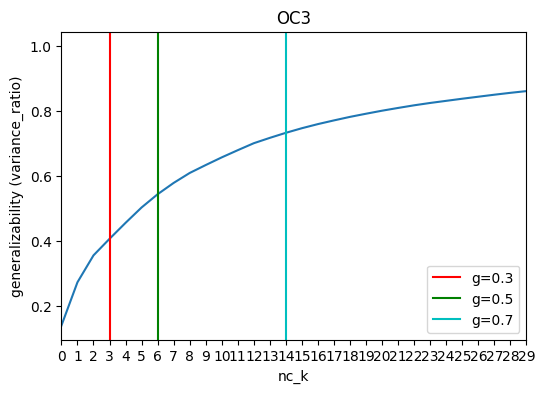

In [237]:
variant = "text_sequence"
OC3_signatures = entity_collection_by_sources(OC3FO_signatures, df_OC3.schema.unique())
pca = sklearn.decomposition.PCA().fit(get_entity_signatures(OC3_signatures, variant))
fig = plt.figure()
plt.title("OC3")
plt.xlabel('nc_k')
plt.ylabel('generalizability (variance_ratio)')
plt.xlim(0,20)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axvline(get_pca_components_given_variance(get_entity_signatures(OC3_signatures, variant), target_variance=.3), c="r", label="g=0.3")
plt.axvline(get_pca_components_given_variance(get_entity_signatures(OC3_signatures, variant), target_variance=.5), c="g", label="g=0.5")
plt.axvline(get_pca_components_given_variance(get_entity_signatures(OC3_signatures, variant), target_variance=.7), c="c", label="g=0.7")
plt.xticks(np.arange(0,30))
plt.legend(loc='lower right')

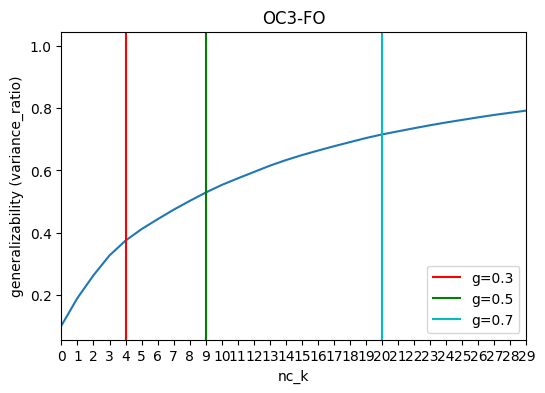

In [238]:
variant = "text_sequence"
pca = sklearn.decomposition.PCA().fit(get_entity_signatures(OC3FO_signatures, variant))
fig = plt.figure()
plt.title("OC3-FO")
plt.xlabel('nc_k')
plt.ylabel('generalizability (variance_ratio)')
plt.xlim(0,20)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axvline(get_pca_components_given_variance(get_entity_signatures(OC3FO_signatures, variant), target_variance=.3), c="r", label="g=0.3")
plt.axvline(get_pca_components_given_variance(get_entity_signatures(OC3FO_signatures, variant), target_variance=.5), c="g", label="g=0.5")
plt.axvline(get_pca_components_given_variance(get_entity_signatures(OC3FO_signatures, variant), target_variance=.7), c="c", label="g=0.7")
plt.xticks(np.arange(0,30))
plt.legend(loc='lower right')

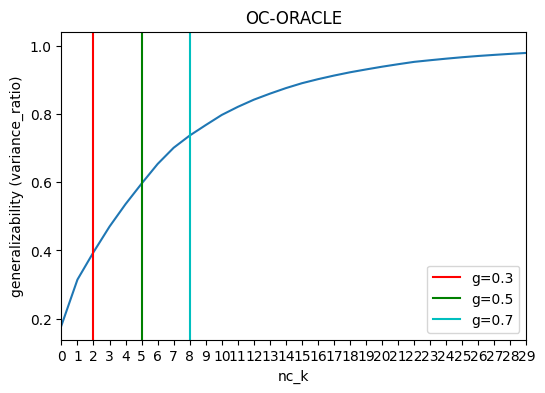

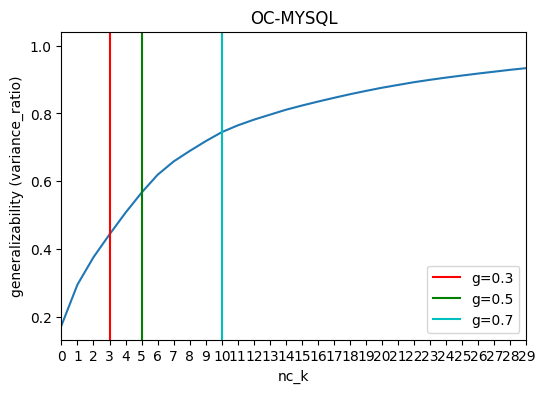

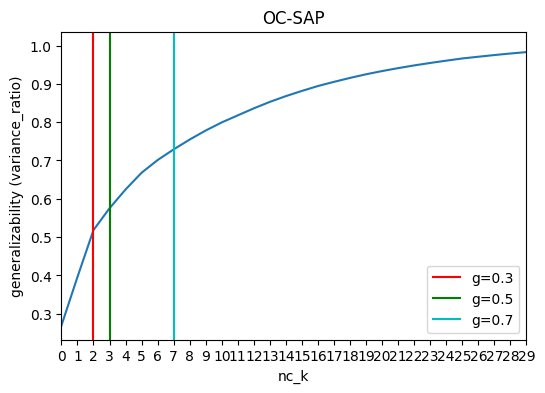

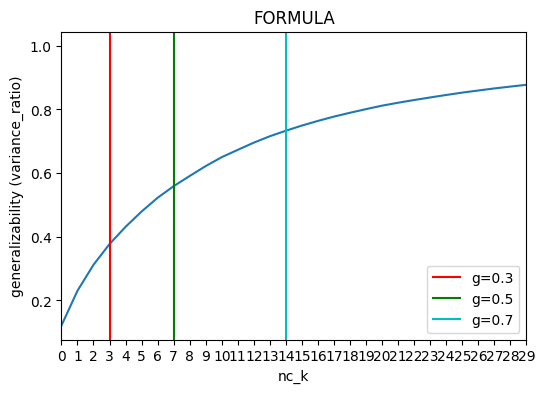

In [239]:
#Generalizability of local PCA models with visualization
for source_name in df_OC3FO.schema.unique():
    variant = "text_sequence"
    entities_source = entity_collection_by_source(OC3FO_signatures, source_name)
    pca = sklearn.decomposition.PCA().fit(get_entity_signatures(entities_source, variant))
    fig = plt.figure()
    plt.title(source_name)
    plt.xlabel('nc_k')
    plt.ylabel('generalizability (variance_ratio)')
    plt.xlim(0,20)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.axvline(get_pca_components_given_variance(get_entity_signatures(entities_source, variant), target_variance=.3), c="r", label="g=0.3")
    plt.axvline(get_pca_components_given_variance(get_entity_signatures(entities_source, variant), target_variance=.5), c="g", label="g=0.5")
    plt.axvline(get_pca_components_given_variance(get_entity_signatures(entities_source, variant), target_variance=.7), c="c", label="g=0.7")
    plt.xticks(np.arange(0,30))
    plt.legend(loc='lower right')

# 5. Scoping

In [39]:
p_list = np.arange(1,100,1)
p_list =  [ float("%.2f" % elem) for elem in p_list ]
print(p_list)
len(p_list)

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0]


99

## Z-Score

In [40]:
#scoping zscore
def scoping_zscore(signatures, df, variant="text_sequence"):
  E_source_names = df.schema.unique()
  signatures_filter_df = entity_collection_by_sources(signatures, E_source_names)

  df["re_zscore"] = method_zscore(get_entity_signatures(signatures_filter_df, variant=variant))
  df_sorted = df.sort_values(by=["re_zscore"]).reset_index(drop=True)

  return df_sorted

In [41]:
def scoping_zscore_plot(signatures, df, variant, performance_only=False):
  accuracies = []
  E_prime_len = []
  df_sorted = scoping_zscore(signatures, df, variant=variant)
  for p in p_list:
    E_prime_distinct = entity_collection_to_block(df_sorted, 0, p).id.values
    df["predict_linkability"] = df.apply(lambda x: set_labels(x.id, E_prime_distinct), axis = 1)
    df["confusion"] = df.apply(lambda x: set_confusion(x.label_linkability, x.predict_linkability), axis = 1)
    accuracies.append(get_metrics(df, print_metrics=False))
    E_prime_len.append(len(set(E_prime_distinct)))

  if performance_only:
    return plot_accuracies(p_list, accuracies, get_metrics=True, print_metrics=False, plot=False) + [plot_auc_roc(accuracies, get_metrics=True, plot=False, smooth=0.2)]
  else:
    plot_accuracies(p_list, accuracies, get_metrics=False, print_metrics=True)
    plot_auc_roc(accuracies)
    plot_auc_pr(accuracies)

## LOF

In [42]:
#scoping lof
def scoping_lof(signatures, df, variant="text_sequence", n_neighbors=20):
  E_source_names = df.schema.unique()
  signatures_filter_df = entity_collection_by_sources(signatures, E_source_names)

  df["re_lof"] = method_clf(get_entity_signatures(signatures_filter_df, variant=variant), n_neighbors=n_neighbors)
  df_sorted = df.sort_values(by=["re_lof"]).reset_index(drop=True)  

  return df_sorted

In [43]:
def scoping_lof_plot(signatures, df, variant, n_neighbors=20, performance_only=False):
  accuracies = []
  E_prime_len = []
  df_sorted = scoping_lof(signatures, df, variant=variant, n_neighbors=n_neighbors)
  for p in p_list:   
    E_prime_distinct = entity_collection_to_block(df_sorted, 0, p).id.values
    # Confusion Matrix Analysis
    df["predict_linkability"] = df.apply(lambda x: set_labels(x.id, E_prime_distinct), axis = 1)
    df["confusion"] = df.apply(lambda x: set_confusion(x.label_linkability, x.predict_linkability), axis = 1)
    accuracies.append(get_metrics(df, print_metrics=False))
    E_prime_len.append(len(set(E_prime_distinct)))

  if performance_only:
    return plot_accuracies(p_list, accuracies, get_metrics=True, print_metrics=False, plot=False) + [plot_auc_roc(accuracies, get_metrics=True, plot=False, smooth=0.2)]
  else:
    plot_accuracies(p_list, accuracies, get_metrics=False, print_metrics=True)
    plot_auc_roc(accuracies)
    plot_auc_pr(accuracies)

## PCA

In [44]:
#scoping pca
def scoping_pca(signatures, df, model_degree_variance, variant="text_sequence"):

  E_source_names = df.schema.unique()
  signatures_filter_df = entity_collection_by_sources(signatures, E_source_names)

  #nComp = get_pca_components_given_variance(get_entity_signatures(signatures_filter_df, variant=variant), target_variance=model_degree_variance)
  #df["re_pca"],_,_ = method_pca(get_entity_signatures(signatures_filter_df, variant=variant), nComp)
  df["re_pca"],_,_ = method_pca_variance(get_entity_signatures(signatures_filter_df, variant=variant), model_degree_variance)
  
  df_sorted = df.sort_values(by=["re_pca"]).reset_index(drop=True)

  return df_sorted

In [45]:
def scoping_pca_plot(signatures, df, variant, model_degree_variance=0.7, performance_only=False):
  accuracies = []
  E_prime_len = []
  df_sorted = scoping_pca(signatures, df, model_degree_variance=model_degree_variance, variant=variant)
  for p in p_list:
    E_prime_distinct = entity_collection_to_block(df_sorted, 0, p).id.values
     # Confusion Matrix Analysis
    df["predict_linkability"] = df.apply(lambda x: set_labels(x.id, E_prime_distinct), axis = 1)
    df["confusion"] = df.apply(lambda x: set_confusion(x.label_linkability, x.predict_linkability), axis = 1)
    accuracies.append(get_metrics(df, print_metrics=False))
    E_prime_len.append(len(set(E_prime_distinct)))
  
  if performance_only:
    return plot_accuracies(p_list, accuracies, get_metrics=True, print_metrics=False, plot=False) + [plot_auc_roc(accuracies, get_metrics=True, plot=False, smooth=0.2)]
  else:
    plot_accuracies(p_list, accuracies, get_metrics=False, print_metrics=True)
    plot_auc_roc(accuracies)
    plot_auc_pr(accuracies)

## Autoencoder

In [46]:
#scoping ae
def scoping_ae(signatures, df, variant="text_sequence", no_execution=10, loss=losses.MeanSquaredError(), epochs=50, activation='relu'):
  df["re_ae"] = 0
  E_source_names = df.schema.unique()
  signatures_filter_df = entity_collection_by_sources(signatures, E_source_names)
  for i in range(no_execution):
    re_ae,_ = method_ae(get_entity_signatures(signatures_filter_df, variant=variant), loss=loss, epochs=epochs, activation=activation)
    df["re_ae"] = df["re_ae"] + re_ae

  df_sorted = df.sort_values(by=["re_ae"]).reset_index(drop=True)

  return df_sorted

In [47]:
def scoping_ae_plot(signatures, df, variant, no_execution=10, loss=losses.MeanSquaredError(), epochs=50, activation='relu', performance_only=False):
  accuracies = []
  E_prime_len = []
  df_sorted = scoping_ae(signatures, df, variant=variant, no_execution=no_execution, loss=loss, epochs=epochs, activation=activation)
  for p in p_list:
    E_prime_distinct = entity_collection_to_block(df_sorted, 0, p).id.values
    # Confusion Matrix Analysis
    df["predict_linkability"] = df.apply(lambda x: set_labels(x.id, E_prime_distinct), axis = 1)
    df["confusion"] = df.apply(lambda x: set_confusion(x.label_linkability, x.predict_linkability), axis = 1)   
    accuracies.append(get_metrics(df, print_metrics=False))
    E_prime_len.append(len(set(E_prime_distinct)))
  
  if performance_only:
    return plot_accuracies(p_list, accuracies, get_metrics=True, print_metrics=False, plot=False) + [plot_auc_roc(accuracies, get_metrics=True, plot=False, smooth=0.2)]
  else:
    plot_accuracies(p_list, accuracies, get_metrics=False, print_metrics=True)
    plot_auc_roc(accuracies)
    plot_auc_pr(accuracies)

# 6. Collaborative Scoping

In [48]:
generalizability_list = list(reversed(p_list))
print(generalizability_list)
len(generalizability_list)

[99.0, 98.0, 97.0, 96.0, 95.0, 94.0, 93.0, 92.0, 91.0, 90.0, 89.0, 88.0, 87.0, 86.0, 85.0, 84.0, 83.0, 82.0, 81.0, 80.0, 79.0, 78.0, 77.0, 76.0, 75.0, 74.0, 73.0, 72.0, 71.0, 70.0, 69.0, 68.0, 67.0, 66.0, 65.0, 64.0, 63.0, 62.0, 61.0, 60.0, 59.0, 58.0, 57.0, 56.0, 55.0, 54.0, 53.0, 52.0, 51.0, 50.0, 49.0, 48.0, 47.0, 46.0, 45.0, 44.0, 43.0, 42.0, 41.0, 40.0, 39.0, 38.0, 37.0, 36.0, 35.0, 34.0, 33.0, 32.0, 31.0, 30.0, 29.0, 28.0, 27.0, 26.0, 25.0, 24.0, 23.0, 22.0, 21.0, 20.0, 19.0, 18.0, 17.0, 16.0, 15.0, 14.0, 13.0, 12.0, 11.0, 10.0, 9.0, 8.0, 7.0, 6.0, 5.0, 4.0, 3.0, 2.0, 1.0]


99

In [49]:
##collaborative scoping
def collaborative_scoping(signatures, df, model_degree_variance, threshold, agreement=2, print_params=False, variant="text_sequence"):

  E_source_names = df.schema.unique()
  signatures_filter_df = entity_collection_by_sources(signatures, E_source_names)

  if isinstance(model_degree_variance, list):
    E_number_components = model_degree_variance
    if print_params:
      print(E_source_names)
      print("Custom Generalizability: " + str(E_number_components))
  else:
    E_number_components = [get_pca_components_given_variance(get_entity_signatures(entity_collection_by_source(signatures_filter_df, source_name), variant), model_degree_variance/100) for source_name in E_source_names]
    if print_params:
      print(E_source_names)
      print("Shared Generalizability: ("+ str(model_degree_variance) + "): " + str(E_number_components))

  #E_models = [method_pca(get_entity_signatures(entity_collection_by_source(signatures_filter_df, source_name), variant), E_number_components[i]) for i, source_name in enumerate(E_source_names)]
  E_models = [method_pca_variance(get_entity_signatures(entity_collection_by_source(signatures_filter_df, source_name), variant), model_degree_variance/100) for i, source_name in enumerate(E_source_names)]
  
  E_local_thresholds = [model[0].describe()[threshold] for model in E_models]

  local_signatures = get_entity_signatures(signatures_filter_df, variant)
  for i, source_name in enumerate(E_source_names):
    #df[source_name] = get_reconstruction_error_PCA(ce, E_models[i][1], E_models[i][2], nComp=E_number_components[i])
    df[source_name] = pca_encode_decode(local_signatures, E_models[i][1], E_models[i][2])
      
  E_local_primes = [list(df[(df[source_name] < E_local_thresholds[i])].id.values) for i, source_name in enumerate(E_source_names)]

  E_prime = []
  for i, source_name in enumerate(E_source_names):
    E_prime = E_local_primes[i] + E_prime
    #track agreement by source
    df[source_name+"_agree"] = 0 #disagree
    df.loc[df.id.isin(E_local_primes[i]), source_name+"_agree"] = 1 #agree

  #count agreements and filter
  df['overall_agreement'] = df[[source_name+"_agree" for source_name in E_source_names]].sum(axis=1)
  E_prime_agreed = list(df[df.overall_agreement >= agreement].id)

  # Confusion Matrix Analysis
  df["predict_linkability"] = df.apply(lambda x: set_labels(x.id, E_prime_agreed), axis = 1)
  df["confusion"] = df.apply(lambda x: set_confusion(x.label_linkability, x.predict_linkability), axis = 1)

  return E_prime_agreed, df

In [50]:
def collaborative_scoping_plot(signatures, df, variant, x_label="$v$ in %", performance_only=False):
    accuracies = []
    E_prime_len = []
    for generalizability in generalizability_list:
        E_prime, df_performance = collaborative_scoping(signatures, df, generalizability, "max", print_params=False, variant=variant)
        accuracies.append(get_metrics(df_performance, print_metrics=False))
        #df_stats["LAAR_g"+str(generalizability)] = get_collaborative_agreement_stats(df_performance)["linkable_agree_agree_ratio"]
        E_prime_len.append(len(set(E_prime)))
    
    if performance_only:
        return plot_accuracies(generalizability_list, accuracies, get_metrics=True, print_metrics=False, plot=False, x_label=x_label) + [plot_auc_roc(accuracies, get_metrics=True, plot=False, smooth=0.2)]
    else:
        plot_accuracies(generalizability_list, accuracies, get_metrics=False, print_metrics=True, x_label=x_label)
        plot_auc_roc(accuracies)
        plot_auc_pr(accuracies)

# 7. Evaluation

## Table

In [292]:
results = []

In [ ]:
results.append(["Scoping", "Z-Score", "OC3"] + scoping_zscore_plot(OC3FO_signatures, df_OC3, "text_sequence", performance_only=True))
results.append(["Scoping", "Z-Score", "OC3-FO"] + scoping_zscore_plot(OC3FO_signatures, df_OC3FO, "text_sequence", performance_only=True))

In [294]:
results.append(["Scoping", "LOF(n=20)", "OC3"] + scoping_lof_plot(OC3FO_signatures, df_OC3, "text_sequence", performance_only=True))
results.append(["Scoping", "LOF(n=20)", "OC3-FO"] + scoping_lof_plot(OC3FO_signatures, df_OC3FO, "text_sequence", performance_only=True))

In [295]:
results.append(["Scoping", "PCA(v=0.3)", "OC3"] + scoping_pca_plot(OC3FO_signatures, df_OC3, "text_sequence", model_degree_variance=0.3, performance_only=True))
results.append(["Scoping", "PCA(v=0.5)", "OC3"] + scoping_pca_plot(OC3FO_signatures, df_OC3, "text_sequence", model_degree_variance=0.5, performance_only=True))
results.append(["Scoping", "PCA(v=0.7)", "OC3"] + scoping_pca_plot(OC3FO_signatures, df_OC3, "text_sequence", model_degree_variance=0.7, performance_only=True))
results.append(["Scoping", "PCA(v=0.3)", "OC3-FO"] + scoping_pca_plot(OC3FO_signatures, df_OC3FO, "text_sequence", model_degree_variance=0.3, performance_only=True))
results.append(["Scoping", "PCA(v=0.5)", "OC3-FO"] + scoping_pca_plot(OC3FO_signatures, df_OC3FO, "text_sequence", model_degree_variance=0.5, performance_only=True))
results.append(["Scoping", "PCA(v=0.7)", "OC3-FO"] + scoping_pca_plot(OC3FO_signatures, df_OC3FO, "text_sequence", model_degree_variance=0.7, performance_only=True))

In [296]:
results.append(["Scoping", "AE", "OC3"] + scoping_ae_plot(OC3FO_signatures, df_OC3, "text_sequence", performance_only=True))
results.append(["Scoping", "AE", "OC3-FO"] + scoping_ae_plot(OC3FO_signatures, df_OC3FO, "text_sequence", performance_only=True))

In [297]:
results.append(["Collaborative Scoping", "PCA", "OC3"] + collaborative_scoping_plot(OC3FO_signatures, df_OC3, "text_sequence", performance_only=True))
results.append(["Collaborative Scoping", "PCA", "OC3-FO"] + collaborative_scoping_plot(OC3FO_signatures, df_OC3FO, "text_sequence", performance_only=True))

In [298]:
df_results = pd.DataFrame(data=results, columns=["method", "oda", "dataset", "AUC_F1", "AUC_ROC", "AUC_PR", "AUC_ROC'"]).sort_values(by="dataset").reset_index(drop=True)  

In [299]:
df_results

,method,oda,dataset,AUC_F1,AUC_ROC,AUC_PR,AUC_ROC'
0,Scoping,Z-Score,OC3,51.643333,61.665885,61.933626,64.067607
1,Scoping,LOF(n=20),OC3,52.516905,63.236443,61.785824,65.997371
2,Scoping,PCA(v=0.3),OC3,55.235377,67.713705,67.011881,70.335151
3,Scoping,PCA(v=0.5),OC3,58.266386,73.636506,71.767795,76.398482
4,Scoping,PCA(v=0.7),OC3,54.404268,66.721363,65.528196,69.229252
5,Scoping,AE,OC3,56.610266,70.721988,68.775745,73.390928
6,Collaborative Scoping,PCA,OC3,61.819928,64.260041,76.393035,82.519779
7,Scoping,Z-Score,OC3-FO,35.522401,55.510589,35.514005,56.390520
8,Scoping,LOF(n=20),OC3-FO,36.757451,56.149586,35.494670,57.785494
9,Scoping,PCA(v=0.3),OC3-FO,47.040698,72.882181,57.984591,74.249561


In [300]:
#df_results.to_csv("evaluation_raw_results_03022025.csv", index=False, encoding='utf-8-sig')

## Plots

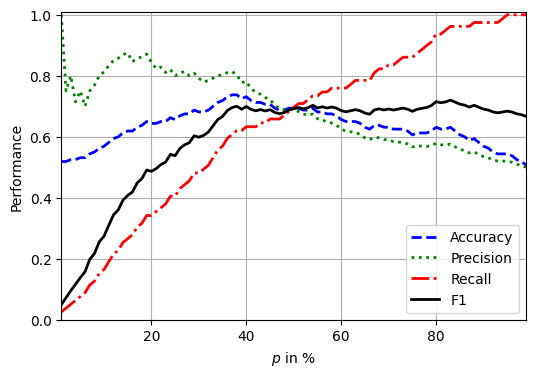

AUC F1:  58.266386045068664
AUC ROC: 73.63650570401626
AUC PR: 71.76779478673765


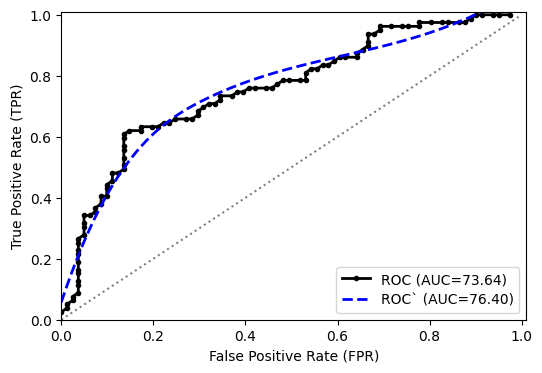

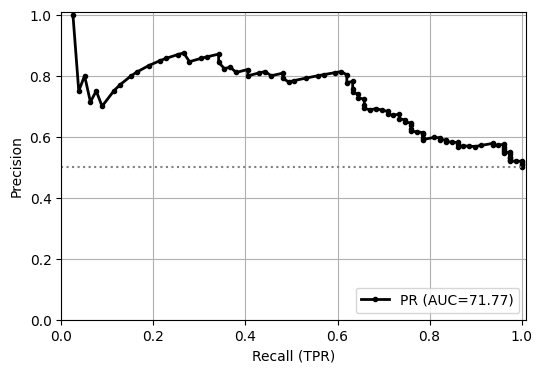

In [301]:
scoping_pca_plot(OC3FO_signatures, df_OC3, "text_sequence", model_degree_variance=0.5)

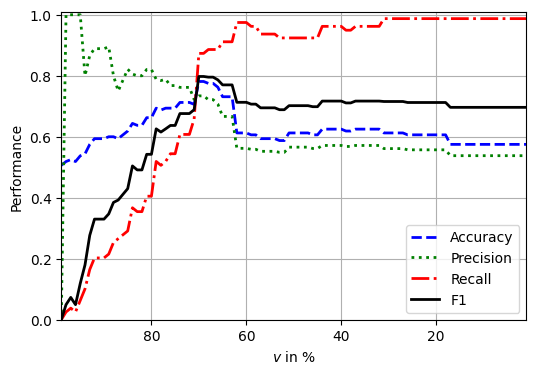

AUC F1:  61.81992774351248
AUC ROC: 64.26004063134864
AUC PR: 76.39303521441573


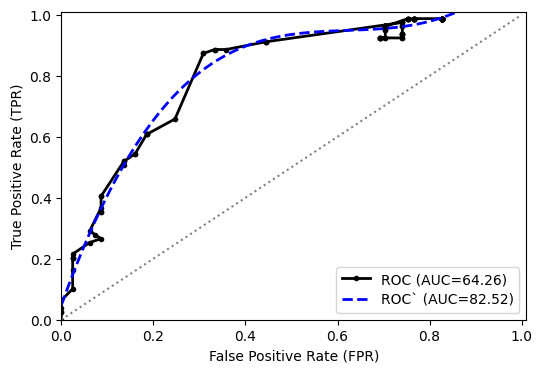

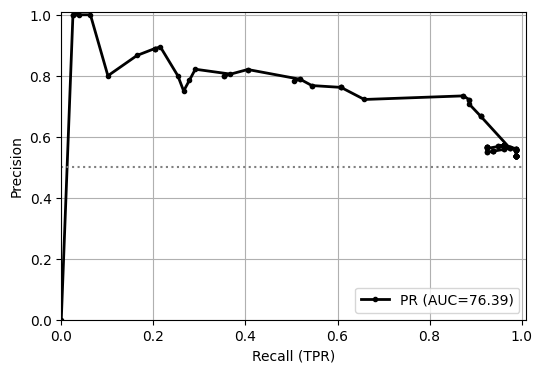

In [51]:
collaborative_scoping_plot(OC3FO_signatures, df_OC3, "text_sequence")

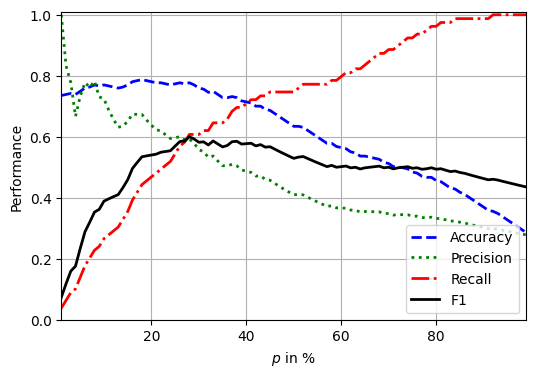

AUC F1:  47.97390549437677
AUC ROC: 75.55379746835443
AUC PR: 55.223128818617504


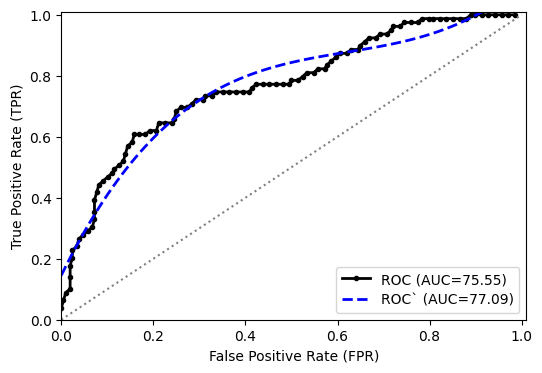

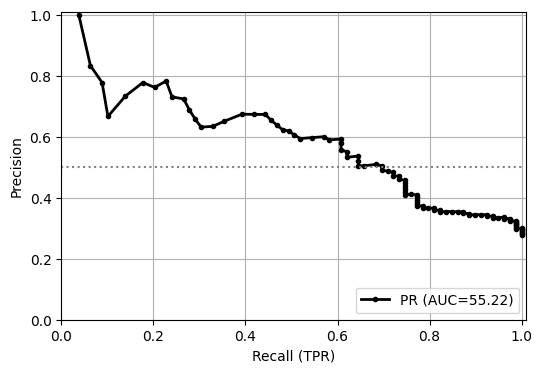

In [303]:
scoping_pca_plot(OC3FO_signatures, df_OC3FO, "text_sequence", model_degree_variance=0.5)

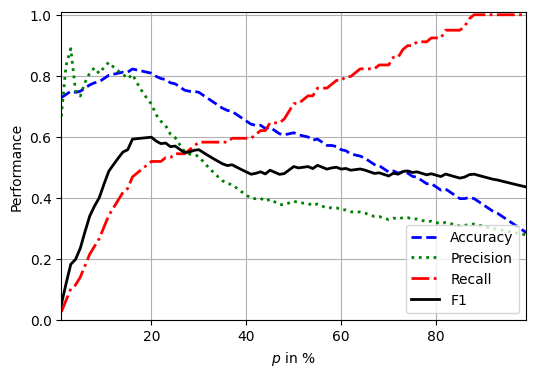

AUC F1:  47.04069786692781
AUC ROC: 72.88218111002921
AUC PR: 57.984590506922906


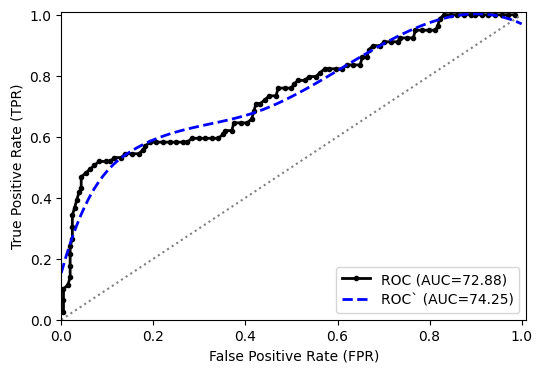

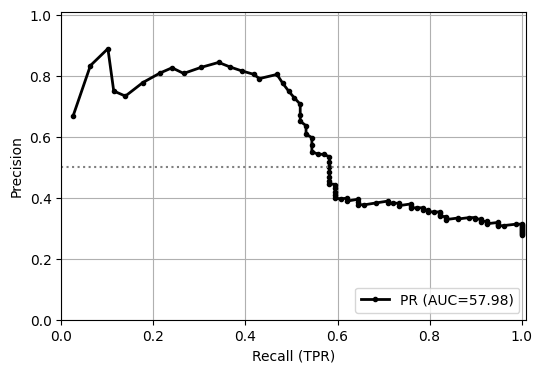

In [304]:
scoping_pca_plot(OC3FO_signatures, df_OC3FO, "text_sequence", model_degree_variance=0.3)

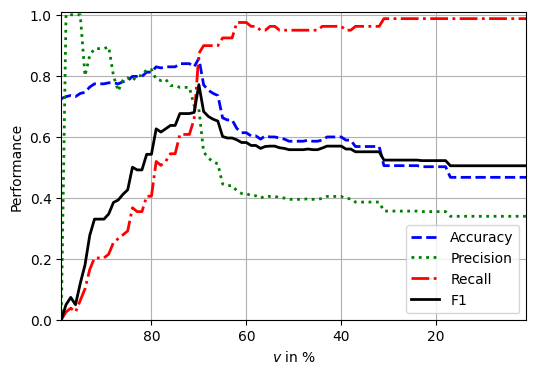

AUC F1:  50.443661078813534
AUC ROC: 62.32655793573514
AUC PR: 73.51212671440182


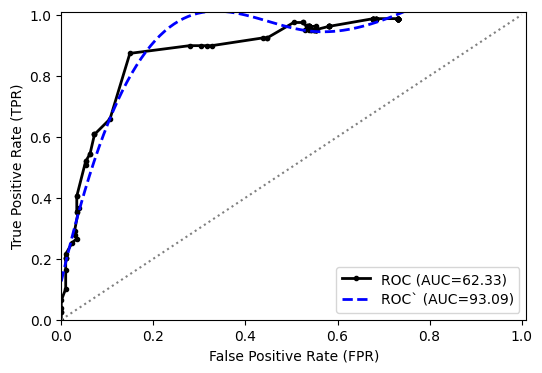

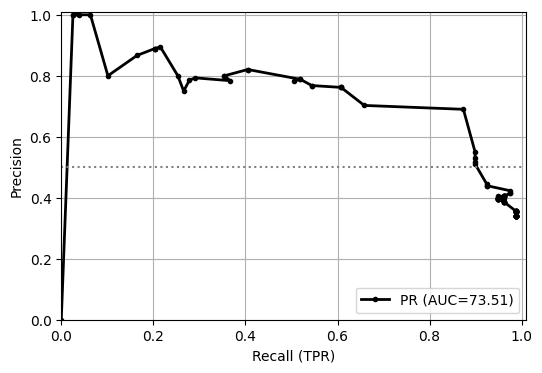

In [52]:
collaborative_scoping_plot(OC3FO_signatures, df_OC3FO, "text_sequence")